In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [75]:
import pandas as pd
import numpy as np
import os
import warnings
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cab
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import log_loss, recall_score, precision_score,roc_auc_score, confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
import shap
import scikitplot as skplt
import importlib
import jm_mp
importlib.reload(jm_mp)

<module 'jm_mp' from 'C:\\Users\\jmu\\Documents\\wd2\\py36v2\\jm_mp.py'>

In [3]:
df_processed = pd.read_parquet(r'D:\z7z8\jpm\archive\processed_dataset.parquet')

In [6]:
df_processed.isna().sum()

response_hours                0
Longitude                 11119
Latitude                  11119
Agency Name                   0
Complaint Type                0
Location Type              2670
Address Type               2331
City                      10596
Status                        0
Community Board            1577
Borough                    1577
Open Data Channel Type        0
Park Borough               1577
campaign_year                 0
campaign_month                0
campaign_trend                0
sub_Descriptor                0
Weekday                       0
dtype: int64

In [12]:
df_processed.columns

Index(['response_hours', 'Longitude', 'Latitude', 'Agency Name',
       'Complaint Type', 'Location Type', 'Address Type', 'City', 'Status',
       'Community Board', 'Borough', 'Open Data Channel Type', 'Park Borough',
       'campaign_year', 'campaign_month', 'campaign_trend', 'sub_Descriptor',
       'Weekday'],
      dtype='object')

### XGBOOST

#### Create Data: Parameter tunning, Train,Test

In [29]:
dummy_cols = ['Agency Name','Complaint Type', 'Location Type', 'Address Type', 
              'City', 'Status','Community Board', 'Borough', 'Open Data Channel Type', 
              'Park Borough','sub_Descriptor','Weekday']

num_features = [x for x in df_processed.columns[1:] if x not in dummy_cols]

dummy_var_list = [df_processed[num_features]]
for feat in dummy_cols:
    df_temp = pd.get_dummies(df_processed[feat])
    df_temp.columns = [' '.join([feat,a]) for a in df_temp.columns]
    print(feat,df_temp.shape)
    dummy_var_list.append(df_temp)

Agency Name (501831, 43)
Complaint Type (501831, 22)
Location Type (501831, 7)
Address Type (501831, 3)
City (501831, 47)
Status (501831, 4)
Community Board (501831, 77)
Borough (501831, 6)
Open Data Channel Type (501831, 5)
Park Borough (501831, 6)
sub_Descriptor (501831, 60)
Weekday (501831, 7)


In [30]:
X_xgb = functools.reduce(lambda x,y: pd.concat([x,y],axis =1),dummy_var_list)
y_xgb = df_processed['response_hours']
print(X_xgb.shape,y_xgb.shape)

(501831, 292) (501831,)


In [31]:
df_tun_xgb = pd.concat([X_xgb,y_xgb],axis =1).sample(frac = 0.1).reset_index(drop = True)
y_tun_xgb = df_tun_xgb['response_hours']
df_tun_xgb.drop('response_hours',axis =1,inplace =True)
X_train_xgb,X_test_xgb,y_train_xgb,y_test_xgb = train_test_split(X_xgb,y_xgb,random_state = 99)

#### Tunning Hyperamaters

In [32]:
%%time
params_dict_xgb  = {'max_depth':[3,4,5],
               'n_estimators':[100,200,300,400,500],
               'learning_rate':np.arange(0.01,0.2,0.03),
               'reg_lambda':np.arange(0.1,6,0.5),
               'gamma':np.arange(0,6,1)}


xgbr= xgb.XGBRegressor(objective = 'reg:linear',early_stopping_rounds=100,eval_metric = 'mae')
rand_cv2 = RandomizedSearchCV(xgbr,param_distributions = params_dict_xgb,cv =4,n_iter =20,n_jobs=3,verbose = True)
rand_cv2.fit(df_tun_xgb,y_tun_xgb)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[22:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 17min 40s


RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=100,
                                          eval_metric='mae', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate

#### Model Fit

In [33]:
%%time
warnings.filterwarnings('ignore')
xgbr= rand_cv2.best_estimator_.fit(X_train_xgb,y_train_xgb)

y_pred_test2 = xgbr.predict(X_test_xgb)
y_pred_train2 = xgbr.predict(X_train_xgb)

[22:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 3min 44s


### CATBOOST

#### Create Data: Parameter tunning, Train,Test

In [53]:
X_cab = df_processed.copy()
X_cab[['Longitude','Latitude']] = X_cab[['Longitude','Latitude']].fillna(-99999)
X_cab = X_cab.fillna('-99999')
y_cab = X_cab['response_hours']

df_tun_cab = X_cab.sample(frac = 0.07).reset_index(drop = True)
y_tun_cab = df_tun_cab['response_hours']
df_tun_cab.drop('response_hours',axis =1,inplace =True)
X_cab.drop('response_hours',axis =1,inplace =True)
X_train_cab,X_test_cab,y_train_cab,y_test_cab = train_test_split(X_cab,y_cab,random_state = 99)

In [54]:
str_features = X_cab.select_dtypes(exclude = [np.number]).columns.tolist()

In [56]:
%%time
params_dict_cab  = {'depth':[3,4,5],
               'iterations':[100,200,300,400,500],
               'learning_rate':list(np.arange(0.01,0.1,0.03)),
               'l2_leaf_reg':list(np.arange(0.1,6,0.8)),
               'min_data_in_leaf':list(np.arange(10,150,20))}
cabr = cab.CatBoostRegressor(early_stopping_rounds=100,eval_metric = 'MAE',
                            cat_features = str_features,verbose = False)

rand_cv = RandomizedSearchCV(cabr,param_distributions = params_dict_cab,cv =4,n_iter =20,n_jobs=3)
rand_cv.fit(df_tun_cab,y_tun_cab)

Wall time: 5min 34s


RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000016188BA4860>,
                   n_iter=20, n_jobs=3,
                   param_distributions={'depth': [3, 4, 5],
                                        'iterations': [100, 200, 300, 400, 500],
                                        'l2_leaf_reg': [0.1, 0.9,
                                                        1.7000000000000002,
                                                        2.5000000000000004,
                                                        3.3000000000000003, 4.1,
                                                        4.9, 5.7],
                                        'learning_rate': [0.01, 0.04,
                                                          0.06999999999999999,
                                                          0.09999999999999999],
                                        'min_data_in_leaf': [10, 30, 50, 70, 90,
                         

In [61]:
# %%time
warnings.filterwarnings('ignore')
cabr= rand_cv.best_estimator_.fit(X_train_cab,y_train_cab)
y_pred_test = cabr.predict(X_test_cab)
y_pred_train = cabr.predict(X_train_cab)

### Check predictions

In [68]:
jm_mp.display_sides(jm_mp.mae_mse_df(y_test_cab,y_pred_test,y_train_cab,y_pred_train,name = 'catboost'),
                   jm_mp.mae_mse_df(y_test_xgb,y_pred_test2,y_train_xgb,y_pred_train2,name = 'xgboost'))

,MAE,MSE
catboost,,
Test Set,26.239,1313.65
Training Set,26.090,1303.36
Difference,-0.149,-10.29
,MAE,MSE
xgboost,,
Test Set,26.199,1299.634
Training Set,25.977,1278.748
Difference,-0.222,-20.886


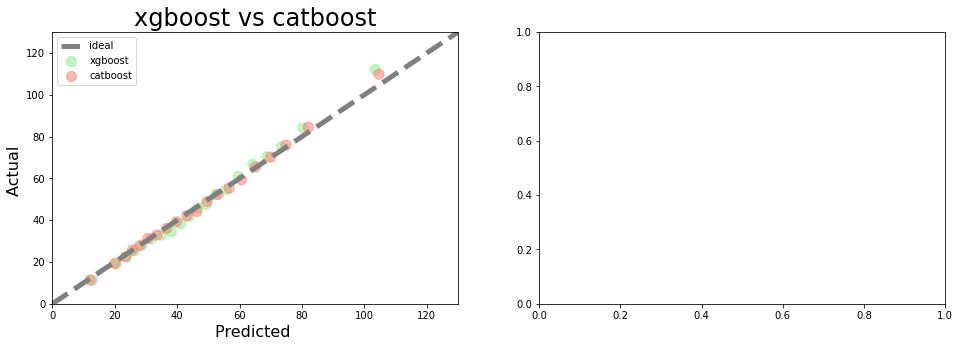

In [76]:
df_s1 = pd.DataFrame({'y':y_test_xgb,
                     'score':y_pred_test2})
df_s2 = pd.DataFrame({'y':y_test_cab,
                     'score':y_pred_test})
fig = jm_mp.create_accuracy_plots(df_s1,df_s2,num_bins = 20,labels = ['xgboost','catboost'],xlim =[0,130],do_regression = True,show_log_odd = True)

In [77]:
!jupyter nbconvert jpm_models.ipynb --to html --output jpm_models.html

[NbConvertApp] Converting notebook jpm_models.ipynb to html
[NbConvertApp] Writing 651177 bytes to jpm_models.html
